In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from math import sqrt
from matplotlib import pyplot as plt
from utilidades.utilities import evaluar_modelo

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import RANSACRegressor, HuberRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV

ModuleNotFoundError: No module named 'utilidades'

## 1. Cargando los datos

In [103]:
dataset = pd.read_csv('..\datos_procesados\datos_procesados.csv')
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,20,0,80.0,9600,0,0,0,0,1,0,...,0,0,0,0,0,5,2007,0,0,181500
2,60,0,68.0,11250,0,0,1,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,70,0,60.0,9550,0,0,1,0,2,0,...,0,0,0,0,0,2,2006,0,1,140000
4,60,0,84.0,14260,0,0,1,0,1,0,...,0,0,0,0,0,12,2008,0,0,250000


## 2. Observando la correlación de todos los features con la variable SalePrice

In [104]:
corr_var = dataset.corr()
corr_var_SalePrice = corr_var.loc['SalePrice',:]
corr_var_SalePrice


MSSubClass      -0.088032
MSZoning        -0.110409
LotFrontage      0.344270
LotArea          0.299962
Street          -0.055601
                   ...   
MoSold           0.051568
YrSold          -0.011869
SaleType         0.089236
SaleCondition    0.188314
SalePrice        1.000000
Name: SalePrice, Length: 79, dtype: float64

#### 2.1 Eliminando los features que no tengan una correlación fuerte con la variable SalePrice (correlación < 0.6)

In [105]:
features_sin_correlacion = corr_var_SalePrice[corr_var_SalePrice<0.6].index.to_list()
dataset = dataset.drop(features_sin_correlacion, axis=1)
dataset

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,7,856,856,1710,2,548,208500
1,6,1262,1262,1262,2,460,181500
2,7,920,920,1786,2,608,223500
3,7,756,961,1717,3,642,140000
4,8,1145,1145,2198,3,836,250000
...,...,...,...,...,...,...,...
1116,6,953,953,1647,2,460,175000
1117,6,1542,2073,2073,2,500,210000
1118,7,1152,1188,2340,1,252,266500
1119,5,1078,1078,1078,1,240,142125


Se puede apreciar que las variables que tienen una mayor correlación con la variable SalePrice son: OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageCars y GarageArea

#### 2.2 Mostrando de nuevo la matrix de correlación

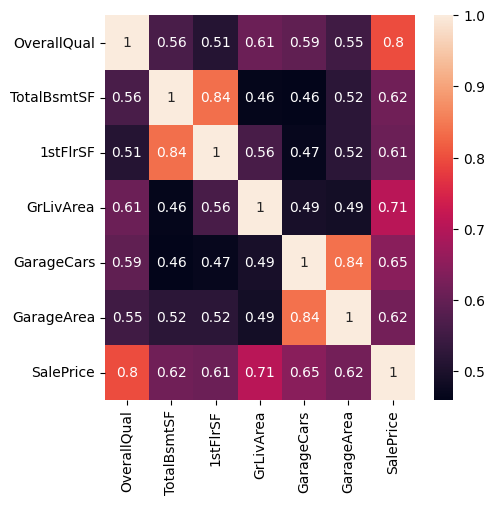

In [106]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(dataset.corr(), annot=True)
plt.show()

## 3. Definiendo los features y la variable a predecir

In [107]:
X = dataset.drop(['SalePrice'], axis=1)
y = dataset[['SalePrice']]

## 3. Se realiza el escalamiento de los datos

In [108]:
esc_rob = RobustScaler()
X_esc = esc_rob.fit_transform(X=X)

## 4. División de los datos en train y test

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_esc, y, test_size=0.3, random_state=42)

## 5. Regresión robusta con Huber

In [110]:
#Entrenando el algoritmo
huber = HuberRegressor(epsilon=1.35)
huber.fit(X=X_train, y=y_train)

c:\Users\diego\Desktop\proyectos_machine_learning\calculo_proyecto_vivienda\venv\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HuberRegressor()

In [111]:
#Evaluando la predicciones
y_pred_train = huber.predict(X=X_train)
y_pred_test = huber.predict(X=X_test)

r2_sc_train = r2_score(y_true=y_train, y_pred=y_pred_train)
r2_sc_test = r2_score(y_true=y_test, y_pred=y_pred_test)

RMSR_train = sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
RMSR_test = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

print("R^2 train: {}".format(r2_sc_train))
print("R^2 test: {}".format(r2_sc_test))

print("\nRMSR train: {}".format(RMSR_train))
print("RMSR test: {}".format(RMSR_test))

R^2 train: 0.7291178179196289
R^2 test: 0.7720629238935048

RMSR train: 41575.91785500358
RMSR test: 42679.639696728045


Se puede apreciar que el RMSR de train y de test son muy parecidos, por lo cual no se aprecia overfitting

## 6. Regresión robusta con Ransac

In [112]:
#Entrenando el algoritmo
ransac = RANSACRegressor()
ransac.fit(X=X_train, y=y_train)

RANSACRegressor()

In [113]:
#Evaluando la predicciones
y_pred_train = ransac.predict(X=X_train)
y_pred_test = ransac.predict(X=X_test)

r2_sc_train = r2_score(y_true=y_train, y_pred=y_pred_train)
r2_sc_test = r2_score(y_true=y_test, y_pred=y_pred_test)

RMSR_train = sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
RMSR_test = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

print("R^2 train: {}".format(r2_sc_train))
print("R^2 test: {}".format(r2_sc_test))

print("\nRMSR train: {}".format(RMSR_train))
print("RMSR test: {}".format(RMSR_test))

R^2 train: 0.6889550260057994
R^2 test: 0.7102681651896948

RMSR train: 44551.59123809151
RMSR test: 48118.420857242374


Se puede apreciar que el RMSR de train y de test son muy parecidos, por lo cual no se aprecia overfitting

## 7. Optimización parámetrica de regresor Huber con búsqueda aleatoria

#### 7. Creando el modelo Huber optimizado

In [114]:
huber = HuberRegressor()

#Cargando la grilla de parámetros
parametros = {
    'epsilon' : np.linspace(1,5,100)
}

#Creando el optimizador
huber_opt = RandomizedSearchCV(
    huber, 
    parametros, 
    n_iter=10, 
    cv=3,
    scoring='neg_mean_absolute_error'
)

#Entrenando el modelo optimizado
huber_opt.fit(X,y)

c:\Users\diego\Desktop\proyectos_machine_learning\calculo_proyecto_vivienda\venv\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\diego\Desktop\proyectos_machine_learning\calculo_proyecto_vivienda\venv\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\diego\Desktop\proyectos_machine_learning\calculo_proyecto_vivienda\venv\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RandomizedSearchCV(cv=3, estimator=HuberRegressor(),
                   param_distributions={'epsilon': array([1.        , 1.04040404, 1.08080808, 1.12121212, 1.16161616,
       1.2020202 , 1.24242424, 1.28282828, 1.32323232, 1.36363636,
       1.4040404 , 1.44444444, 1.48484848, 1.52525253, 1.56565657,
       1.60606061, 1.64646465, 1.68686869, 1.72727273, 1.76767677,
       1.80808081, 1.84848485, 1.88888889, 1.92929293, 1.96969...
       3.82828283, 3.86868687, 3.90909091, 3.94949495, 3.98989899,
       4.03030303, 4.07070707, 4.11111111, 4.15151515, 4.19191919,
       4.23232323, 4.27272727, 4.31313131, 4.35353535, 4.39393939,
       4.43434343, 4.47474747, 4.51515152, 4.55555556, 4.5959596 ,
       4.63636364, 4.67676768, 4.71717172, 4.75757576, 4.7979798 ,
       4.83838384, 4.87878788, 4.91919192, 4.95959596, 5.        ])},
                   scoring='neg_mean_absolute_error')